# English Premier League Strategies

## Problem Statement/Goal

I sought to answer the following question:

Is it possible to glean intuitive clusters around soccer strategy from limited data?

## Description of Data

There were four main sources of data I used:

- Github repositories with high level historical English Premier League data from 2011/2012-2014/2015 seasons
    - This contained multiple repositories and .csv and .json files containing high level statistics by game by season
    - https://github.com/jokecamp/FootballData/tree/master/football-data.co.uk/england
- Weather data set from British weather stations between 2011/2012-2014/2015 seasons
    - Holistic weather data by station within a region (Great Britain) downloaded as a .txt file
    - https://mesonet.agron.iastate.edu/request/download.phtml?network=GB__ASOS
- SQL Premier League data with detailed information about match events from 2011/2012-2014/2015 seasons
    - Downloaded from Kaggle, this database contained both player and match data, both high level and granular
    - https://www.kaggle.com/hugomathien/soccer
- Web-scraped mean data for English Premier League teams from 2011/2012-2014/2015 seasons
    - Scraped season-overview statistics by team for the seasons that were available
    - https://www.whoscored.com/Regions/252/Tournaments/2/Seasons/2458/Stages/4345/TeamStatistics/England-Premier-League-2010-2011

The final dataframe constructed contained ~100 fields, including:

|Field|Description|
|----|----|
|home_team|home team name|
|away_team|away team name|
|Stadium|name of the stadium game was played at|
|Capacity|total capacity of stadium game was played at|
|date|specific timestamp of game start|
|Referee|name of main referee for game if available|
|..._corners|both home and away number of corners during game|
|..._fouls|both home and away number of fouls committed during game|
|..._fouls_for|both home and away number of fouls received during game|
|..._crosses|both home and away number of crosses during game|
|..._shots|both home and away number of total shots during game|
|..._shots_target|both home and away number of shots on target during game|
|..._yellow_cards|both home and away number of yellow cards during game|
|..._red_cards|both home and away number of red cards during game|
|..._possession|both home and away percentage of possession during game|
|..._passing|both home and away passing accuracy percentage during game|
|..._tackles|both home and away number of tackles during game|
|..._dribbles|both home and away number of dribbles during game|
|..._aerials|both home and away number of aerial challenges won during game|
|..._interceptions|both home and away number of interceptions during game|
|temp (F)|actual temperature in Fahrenheit during game|
|wind speed|wind speed in mph during game|
|humidity|humidity percentage during game|

It also included counts of types of goals, shots on target, and shots off target by home/away team and subtype (e.g. home_shoton_freekicks listed the number of freekicks on target for the home team during the game)

## Description of relevant data cleaning

There were three main pieces of data cleaning necessary to do:
- Merging the weather and soccer data
- Scrape the internet for additional season stats
- Parse the necessary information out of the SQL database which contained HTML

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from haversine import haversine
import sqlite3
import datetime
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time as time
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity

sqlite_db = '/home/llevin/Desktop/capstone2/databases/database.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The first piece was to merge the weather data with the soccer data. To do this I had to create a haversine distance, which finds the distance along the Earth's surface between two longitude and latitude coordinates, between each weather station and each stadium location. I then took the near station to each stadium to know which weather to pull from. The below function does this.

In [105]:
def weather_merge(stadiums, stations):
    #for each stadiums lat/long, find the weather station with the  minimum haversine distance and append that
    for index1 in stadiums.index:
        haversines = []
        for index2 in stations.index:
            h = haversine([stadiums.ix[index1,'Latitude'],stadiums.ix[index1,'Longitude']],
                                       [stations.ix[index2,'lat'],stations.ix[index2,'long']])
            haversines.append([h, index2])
        haversines = sorted(haversines, key=lambda x: x[0]) #sorts by the haversine distance
        min_hav = haversines[0]
        min_station = stations.ix[min_hav[1],'station'] 
        stadiums.ix[index1,'closest_station'] = min_station
    return stadiums

The next was from which time to pull the weather. I made the assumption to average the weather information per day and merge that data with each soccer match. This allowed for more games to be included which may not have had weather data associated for the specific fixture time but also didn't drastically alter the weather data included.

In [1]:
# this block of code pulls in the weather data, originally one column of comma delimited cells and splits it into a 
#dataframe. This manual method worked faster than an apply or map function due to the amount of data in the original
#dataset (over ~6MM rows).
weather = pd.read_table('/home/llevin/Desktop/capstone2/weather_data/raw_weather.txt')
weather_clean = weather.iloc[4:]
weather_cl = dict(zip(['station','date','long','lat','temp (F)','dew (F)','humidity','wind direction',
                    'wind speed (mph)','prec (in)','visibility (mi)'],
                   [[],[],[],[],[],[],[],[],[],[],[]]))
cols = ['station','date','long','lat','temp (F)','dew (F)','humidity','wind direction',
                                  'wind speed (mph)','prec (in)','visibility (mi)']
for j, row in enumerate(weather_clean.values):
    if (j % 50000) == 0: #manual verbose statement to track how many cells have been split
        print j
    row = row[0].split(',')
    for i, item in enumerate(row):
        weather_cl[cols[i]].append(item)
weather_cl = pd.DataFrame(weather_cl)
weather_cl.drop(0,inplace=True) #drops log data from the original set
weather_cl.head()

In [4]:
#this adjusts the time data for the weather and soccer dataframes to ensure we can join on this to get the most
#accurate weather data associated with each game.
weather['date'] = pd.to_datetime(weather['date'])
weather['date'] = weather['date'].map(lambda x: datetime.datetime(x.year,x.month,x.day)) #removes the hour from weather
weather = weather.apply(lambda x: x.map(lambda y: 0. if (y=='M' or y==None) else y)) #imputes missing values  to 0
#converts all weather fields to float
weather[['temp (F)','dew (F)','humidity','wind direction','wind speed (mph)','prec (in)','visibility (mi)']] = 
    weather[['temp (F)','dew (F)','humidity','wind direction','wind speed (mph)','prec (in)','visibility (mi)']].apply(lambda x: x.astype(float))
weather = weather.groupby(['station','date']).mean().reset_index() #groups by the station and date, taking the mean
final_input['date'] = pd.to_datetime(final_input['date']) #converts soccer dataframe dates to datetime

The next piece was to scrape the internet and compile additional stats for each team. These are season-long stats and so were scalar values applied to each game a team played that season. This doesn't give variation between teams but can still help the clustering later on. I chose the website WhoScored.com as it had interesting and specific stats such as interceptions per game, tackles, dribbles, and others. I used the Selenium scraping package in order to be able to click through the tables to get to the data I wanted. Scrapy could have been an alternative but would have been a much more in depth process of finding the correct table within each url as different tables did not change the url or table position on the webpage. The below is just a part of the scraping code for brevity. Similar for-loops were created for the offensive and defensive stats I was looking for.

In [107]:
#this is a segment of the scraping code used to gather general soccers statistics across seasons for Premier League
#teams. This data will be passed to each team/game and while will be the same for all games by team it can potentially
#add some comparisons to cluster on. This information was taken where available which was the last 6 years. Using selenium
#I also scraped other tables with the element clicking feature.
scraped_data = pd.DataFrame()
for url,season in zip(urls,seasons): #the seasons and urls were manually input into lists.
    print season
    driver = webdriver.Firefox()
    driver.get(url)
    content = driver.page_source
    soup = BeautifulSoup(content)
    team_list = []
    poss_list = []
    pass_list = []
    aer_list = []
    scrape = pd.DataFrame()
    for row in soup.findAll('tr')[0:21]: #takes the first 20 rows which matched to the 20 teams in a season.
        team = row.find('a',{'class':'team-link'})
        poss = row.find('td',{'class':'possession '})
        pass_ = row.find('td',{'class':'passSuccess '})
        aerial = row.find('td',{'class':'aerialWonPerGame '})
        if team!=None:
            team_list.append(team.get_text())
            poss_list.append(poss.get_text())
            pass_list.append(pass_.get_text())
            aer_list.append(aerial.get_text())
    scrape['Team'] = team_list
    scrape['Possession (%)'] = poss_list
    scrape['Pass Accuracy (%)'] = pass_list
    scrape['Aerials Won'] = aer_list
    scrape['Season'] = season
    sequence = [scraped_data,scrape]
    scraped_data = pd.concat(sequence) #kept adding each season to the final dataframe.
    driver.close()

The final piece was parsing out the values I needed from the SQL database downloaded from Kaggle. This database contained a lot of extraneous information but the fields I was interested in contained an html script within each cell. The below three functions are an example of how I parsed out the types of goals that occured by team by match. This I felt was critical data as I believe different types of goals (headers, freekicks, etc.) can intuitively be linked to different strategies.

In [6]:
#used the BeautifulSoup package to parse out the html which is found within the SQL database. This information was 
#very interesting as it allowed more granualarity into what types of goals, shots, etc. were within each game. 
def clean_html_goals_shots(element):
    try:
        soup = BeautifulSoup(element)
        text = zip(soup.findAll('subtype'),soup.findAll('team')) #finds the subtype within each series and the team associated
        output = []
        for i in text:
            output.append((i[0].get_text(),i[1].get_text()))
        return output
    except:
        return element #if there was a null would return nothing to avoid breaking

In [7]:
#this took the output from the previous function and created additional fields for home and away teams (joined by team_id)
#which contained a list of all the subtypes.
def split_goal_stats(df):
    goal_list = df['goal'].map(clean_html_goals_shots)
    home_full = []
    away_full = []
    for home,lst in zip(df['home_team_api_id'],goal_list):
        home_goals = []
        away_goals = []
        try:
            for i in lst:
                if float(i[1])==home:
                    home_goals.append(i[0])
                else:
                    away_goals.append(i[0])
        except:
            home_goals.append('')
            away_goals.append('')
        home_full.append(home_goals)
        away_full.append(away_goals)
    df['home_goal_types'] = home_full
    df['away_goal_types'] = away_full
    return df

In [ ]:
#This final function created counter fields for each type of subtype within the lists created in the last function.
#Subtypes were grouped into general categories using judgment on what types would be most common throughout games 
#(E.g. bicycle kicks was an option but not taken as it would be too infrequent)
def home_goals(df):
    header_list = []
    freekick_list = []
    volley_list = []
    other_list = []
    for types in df['home_goal_types']:
        headers = 0
        freekicks = 0
        volleys = 0
        others = 0
        for typ in types:
            if 'header' in typ:
                headers += 1
            elif 'freekick' in typ:
                freekicks += 1
            elif 'volley' in typ:
                volleys += 1
            else:
                others += 1
        header_list.append(headers)
        freekick_list.append(freekicks)
        volley_list.append(volleys)
        other_list.append(others)
    df['home_goal_headers'] = header_list
    df['home_goal_freekicks'] = freekick_list
    df['home_goal_volleys'] = volley_list
    df['home_goal_other'] = other_list
    return df

Similar functions were created to parse out shots on target and types, shots off target and types, number of crosses and final possession stats for both home and away teams.

In [ ]:
# A final piece of code to create dummy variables for which stadium each game was played at
def stadium_dummy(df):
    stadiums = list(df['Stadium'].unique())
    for stad in stadiums:
        column = str('at_'+str.strip(stad))
        df[column] = df['Stadium'].map(lambda x: 1 if str.strip(x) in column else 0)
    return df

In [ ]:
# this last piece converts the half time and full time results to numeric values. Instead of simply indexing them, I chose
# to convert the values using soccer results point values from the home team's position. E.g. A win for the home team
# results in 3 points during a soccer season, while a draw is 1 point and a loss for the home team is 0.
final_merge['half_time_result'] = final_merge['half_time_result'].map(lambda x: 3 if x=='H' else 0 if x=='A' else 1)
final_merge['result'] = final_merge['result'].map(lambda x: 3 if x=='H' else 0 if x=='A' else 1)

## EDA

As this is an unsupervised learning problem the EDA is not directed in any way by a target variable. Therefore, I went through the fields I had and tried to visualize and discrepancies or outliers hidden within the dataframe. This can be a never-ending process so I constrained myself in order to leave additional time if I needed to come back.

In [4]:
input_data = pd.read_csv('/home/llevin/Desktop/capstone2/cleaned_data/input_data_vF3.csv')

In [5]:
#As I had nearly 100 fields in a few formats I wanted to created lists of subset columns for EDA and later use.
num_cols = input_data.select_dtypes(include=['int64','float64']).columns
#a few specific fields were removed as to not sway the clustering, such as the team ids which are not relevant
#and the full time goals and results which intuitively cannot play a part in how a team plays during a game.
num_cols = [col for col in num_cols if col not in ['home_team_api_id','away_team_api_id','result',
                                                  'full_time_home_goals','full_time_away_goals']]
home_cols = [col for col in num_cols if 'home' in col]
away_cols = [col for col in num_cols if 'away' in col]

In [6]:
input_cor = input_data[home_cols].corr() #correlation matrix for heatmap

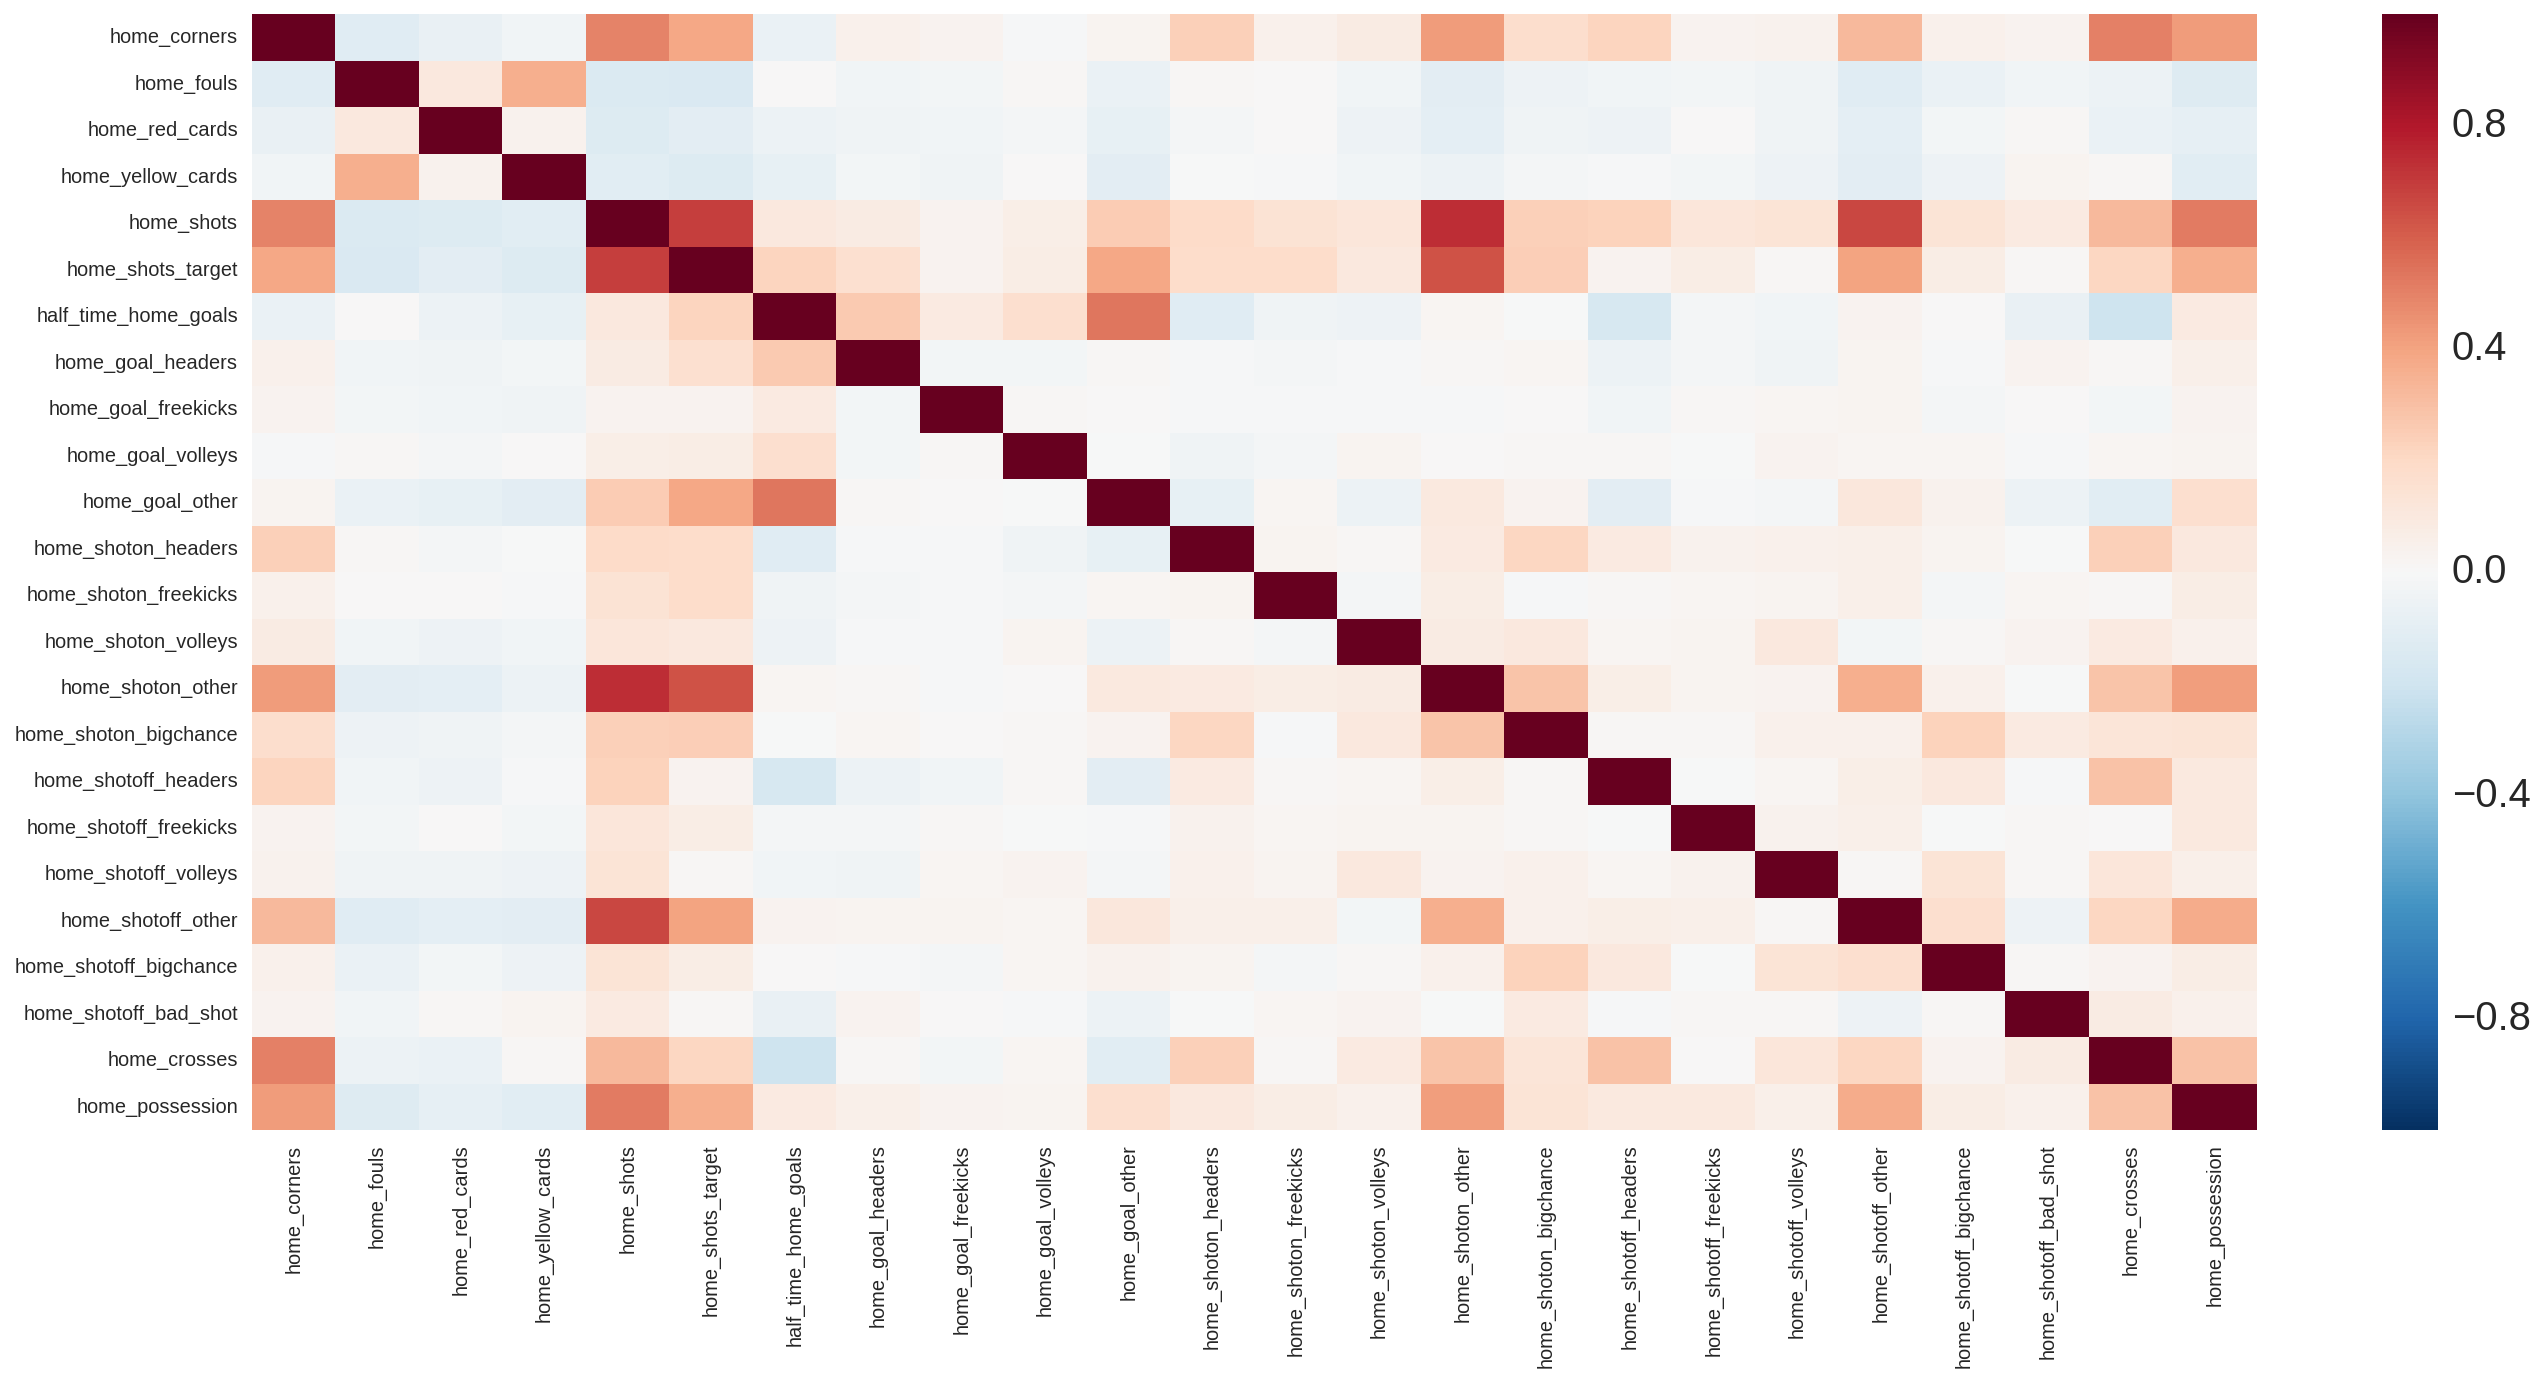

In [7]:
#heatmap of all home_based fields
fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=2)
sns.heatmap(data=input_cor, ax=ax)
plt.show()

The heatmap of home stats shows intuitive data (such as shots heavily linked with goals and shot types) but also showed me that I needed to scale things correctly. For example, Stadium Capacity was a field which was always magnitudes higher than all other stats. In order to make sure the clustering algorithm wasn't skewed by this I normalized all numeric fields to have a mean = 0 and std. deviation = 1. 

/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


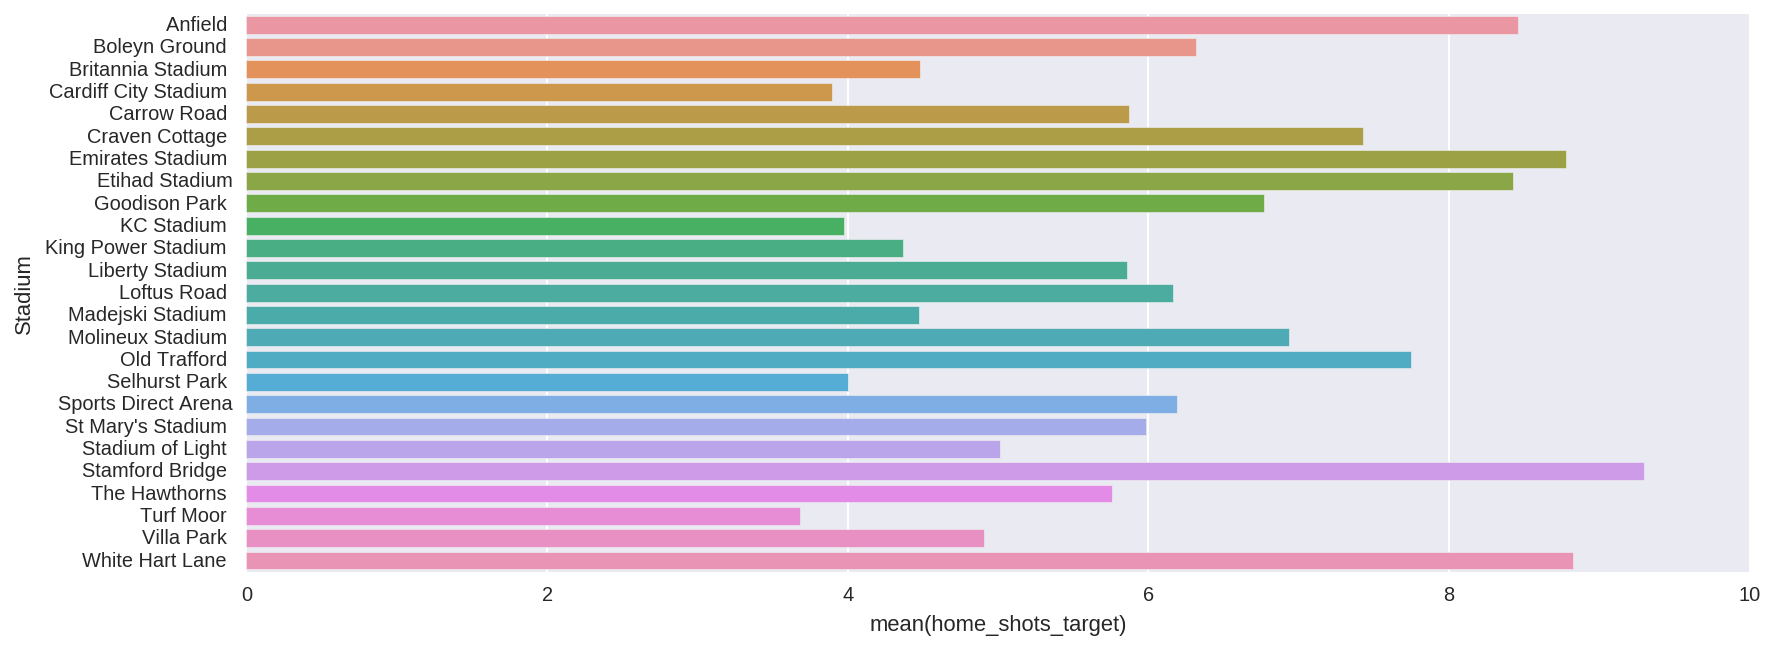

In [8]:
#shows example of mean values by stadium played at.
stadium_group = input_data[[col for col in num_cols]]
stadium_group['Stadium'] = input_data['Stadium']
stadium_group = stadium_group.groupby('Stadium').mean().reset_index()
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(stadium_group['home_shots_target'],stadium_group['Stadium'])
plt.show()

I looked at frequency graphs for all variables grouped by stadium to see if there were oddities or outliers. Most showed intuitive data (e.g. in the graph above the 'best' teams: Arsenal, Manchester City, Chelsea, etc. had a much higher shot count at home than other teams). These did reveal a few stadiums that needed to be removed for lack of games played there.

/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


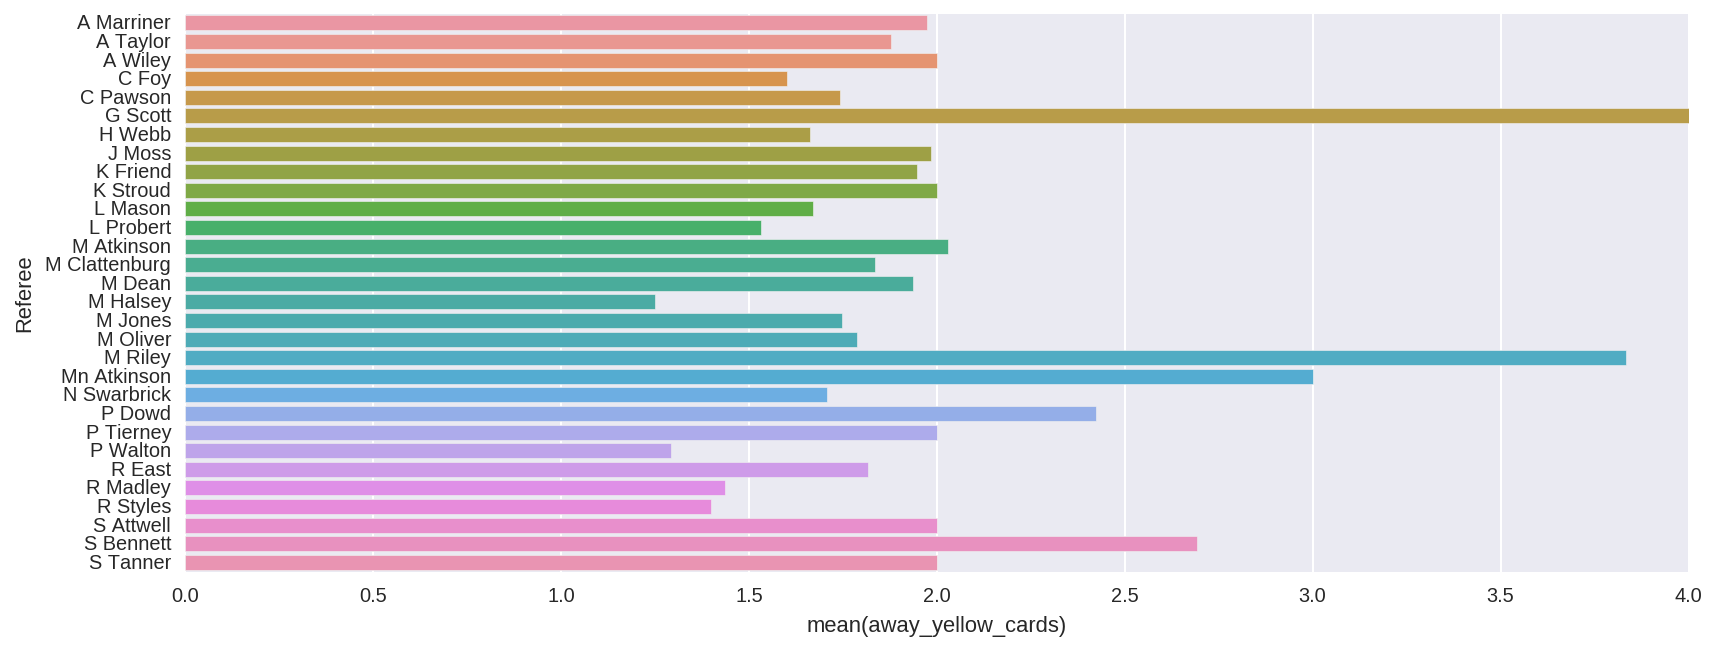

In [9]:
#shows example of values grouped by referee present at game. Referee was not available for all games and ended up being
#removed from the modeling portion to limit clustering fields.
ref_group = input_data[[col for col in num_cols]]
ref_group['Referee'] = input_data['Referee']
ref_group = ref_group.groupby('Referee').mean().reset_index()
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(ref_group['away_yellow_cards'],ref_group['Referee'])
plt.show()

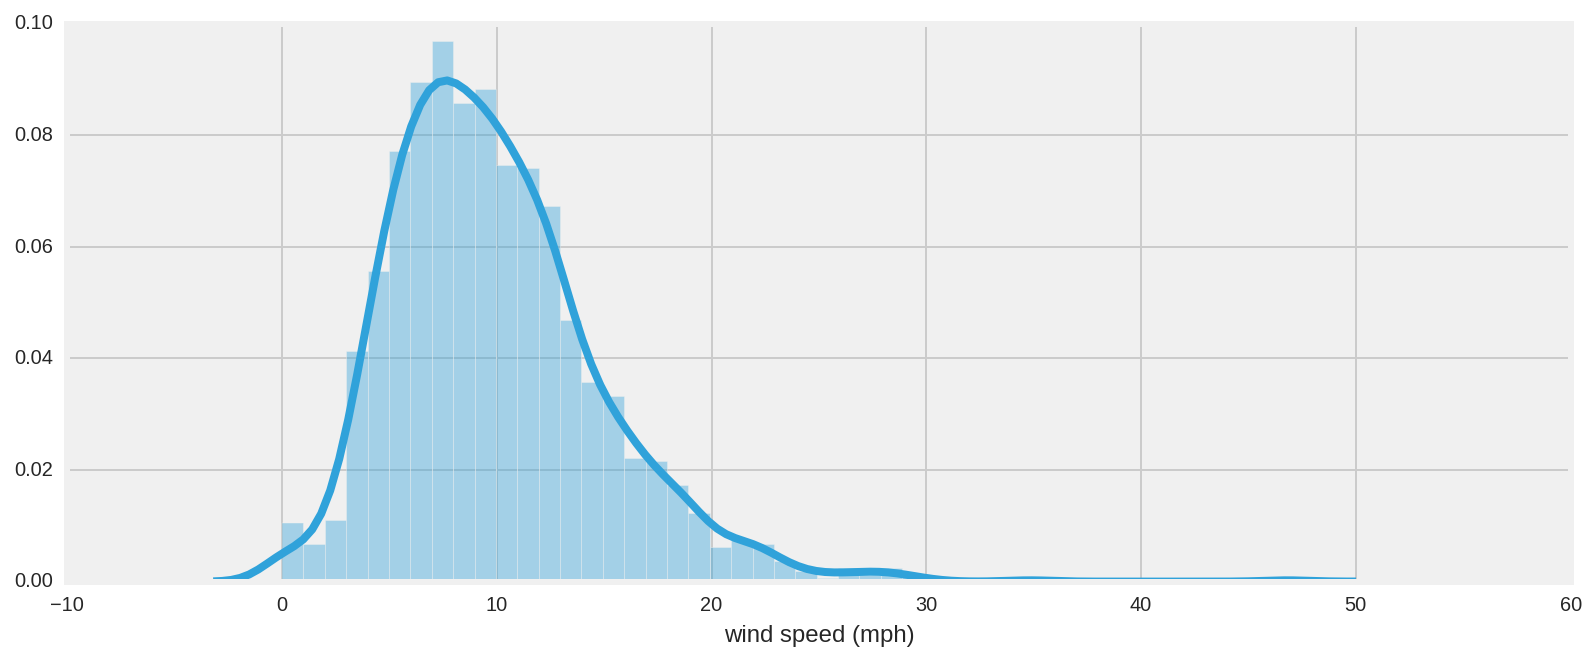

In [64]:
#Example of distribution plot for the weather data to ensure not major outliers were present.
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(input_data['wind speed (mph)'])
plt.show()

These density plots also helped view any outliers by field. For example, it showed that precipitation was not present in the weather data so I had to remove that column.

## Model Selection

Unsupervised clustering problems have a few different models which can be used. The most common are K-Means and DBSCAN. However, the difference between using K-Means (or K-modes or K-Mediods) and DBSCAN or OPTICS is K-Means requires the user to specify a number of clusters to output. This requires a prior belief on how many clusters the data should be outputing. However, as the goal of this was not to create a specific number of clusters but to determine whether any number of clusters created could be translated intuitively, this narrowed down the options to DBSCAN and OPTICS, which is a generalized version of the density-based model which is DBSCAN. 

DBSCAN was chosen between those two simply to account for time and effort as Python does not currently have a built-in or opensource OPTICS package. This is fine because DBSCAN is very good at working with flexible data and data types, which is what this soccer dataset has become (with continuous, discrete, binomial, and other types included).

However, one major piece of any clustering model is the metric used to compute the distance matrix created. Usually Euclidian distance works fine but since I have a mixed set of data types I chose to use the Gower distance, which can be researched here: http://www.clustan.talktalk.net/gower_similarity.html

Python does not include Gower in its sklearn package so the below function was used instead to create the distance matrix.

In [11]:
# this manually computes the gower distance matrix
def dist_gower(datamtx, strict=True):
    """returns a row-row gower dist matrix
    
    see for example, Faith et al., 1987
    
    
    * note that the comparison between any two rows is dependent on the entire
    data matrix, d_ij is a fn of all of datamtx, not just i,j
    * comparisons are between rows (samples)
    * any column containing identical data for all rows is ignored (this
    prevents a 0/0 error in the formula for gower distance
    * input: 2D numpy array.  Limited support for non-2D arrays if 
    strict==False
    * output: numpy 2D array float ('d') type.  shape (inputrows, inputrows)
    for sane input data
    * two rows of all zeros returns 0 distance between them
    * if strict==True, raises ValueError if any of the input data is
    not finite, or if the input data is not a rank 2 array (a matrix).
    * if strict==False, assumes input data is a 2d matrix.  
    If rank of input data is < 2, returns an empty 2d array (shape:
    (0, 0) ).  If 0 rows or 0 colunms, also returns an empty 2d array.
    """
    if strict:
        if not np.isfinite(datamtx).any():
            raise ValueError("non finite number in input matrix")
        if np.ndim(datamtx) != 2:
            raise ValueError("input matrix not 2D")
        numrows, numcols = np.shape(datamtx)
    else:
        try:
            numrows, numcols = np.shape(datamtx)
        except ValueError:
            return np.zeros((0,0),'d')
    if numrows == 0 or numcols == 0:
        return np.zeros((0,0),'d')
    dists = np.zeros((numrows,numrows),'d')
    coldiffs = datamtx.max(axis=0) - datamtx.min(axis=0)
    for i in range(numcols):
        if coldiffs[i] == 0.0:
            coldiffs[i] = 1.0 # numerator will be zero anyway
    for i in range(numrows):
        r1 = datamtx[i]
        for j in range(i):
            r2 = datamtx[j]
            rowdiff = r2 - r1
            dist = sum(abs(r1 - r2) / coldiffs)
            dists[i,j] = dists[j,i] = dist

    return dists

## Results

The results for DBSCAN were unfortunately poor in creating distinct clusters. The below process shows that using both the gower distance as well as the common euclidean distance (having removed all binary fields from the input dataframe), yields mostly one cluster with a few points as outliers or noise. This seems to show that DBSCAN cannot use this data, either for lack of games (~1600) or lack of distinctive statistics or fields.

In [12]:
#normalized data to ensure scales matched
X = input_data[num_cols].values
scale = StandardScaler()
norm_data = scale.fit_transform(X)

The below function runs through a range of max distances and min samples to attempt a DBSCAN clustering on. It uses all possible fields and the gower matrix before returning the highest silhouette score for an option that has multiple clusters and requires more than 1 one min sample and max distance.

In [15]:
#runs through a range of max distances and min samples to create clustering on. Then computes the silhouette score
#and prints out the highest option
def dbscan_gower(df,eps=range(1,20),min_samples=range(1,10)):
    scale = StandardScaler()
    clusters_info = []
    X = df.values
    X_n = scale.fit_transform(X)
    X_gower = dist_gower(X_n)
    for i in eps:
        for j in min_samples:
            db = DBSCAN(eps=i,min_samples=j,metric='precomputed').fit(X_gower)
            labels = db.labels_
            try:
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters_>1 and i>1 and j>1:
                    clusters_info.append([i,j,n_clusters_,metrics.silhouette_score(X_n, labels)])
            except:
                pass
    clusters_info = sorted(clusters_info,reverse=True,key=lambda x: x[3])
    max_sil = clusters_info[0]
    print 'Max Distance: ', max_sil[0]
    print 'Min Samples: ', max_sil[1]
    print 'Number of Clusters: ', max_sil[2]
    print 'Silhouette Score: ', max_sil[3]

dbscan_gower(input_data[num_cols])

Max Distance:  6
Min Samples:  3
Number of Clusters:  4
Silhouette Score:  0.102925115669


In [17]:
#Taking an option for parameters from the previous function, finding the different clusters and applying that cluster
#to each row of the original dataframe in order to look at the differences.
def apply_clusters(df,cols,eps,min_samples):
    X = df[cols].values
    scale = StandardScaler()
    X_n = scale.fit_transform(X)
    X_gower = dist_gower(X_n)
    db = DBSCAN(eps=eps,min_samples=min_samples,metric='precomputed').fit(X_gower)
    labels = db.labels_
    clusters = []
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print set(labels)
    print('Estimated number of clusters: %d' % n_clusters_)
    for i in labels:
        if i == -1:
            clusters.append('noise')
        else:
            clusters.append(str(i))
    df['cluster'] = clusters
    print df['cluster'].value_counts()
    cluster_group = df.groupby('cluster').mean().reset_index()
    return cluster_group

clustered = apply_clusters(input_data,num_cols,6,3)
clustered = clustered[clustered['cluster']!='noise']

set([0, 1, 2, 3, -1])
Estimated number of clusters: 4
0        1390
noise     227
3           3
1           3
2           3
Name: cluster, dtype: int64


The above is the best option using gower which shows almost all games either in cluster 0 or noise. DBSCAN doesn't seem to be able to group these into distinctive clusters, rather finding a few types of outliers to the main cluster. The next option was to remove the binary fields from the input dataframe and use the more common euclidean distance to see if that parameter makes a difference. The below are the same functions as above for DBSCAN clustering only using euclidean distance.

In [21]:
euc_cols = [col for col in num_cols if col not in ['at_Emirates Stadium','at_Boleyn Ground','at_King Power Stadium'
                                                   ,'at_Old Trafford','at_Loftus Road','at_Britannia Stadium'
                                                   ,'at_The Hawthorns','at_Anfield','at_Sports Direct Arena'
                                                   ,'at_Turf Moor','at_Villa Park','at_Stamford Bridge','at_Selhurst Park'
                                                   ,'at_Goodison Park',"at_St Mary's Stadium",'at_Liberty Stadium',
                                                   'at_KC Stadium','at_Stadium of Light','at_White Hart Lane'
                                                   ,'at_Etihad Stadium','at_Carrow Road','at_Molineux Stadium',
                                                   'at_Cardiff City Stadium','at_Craven Cottage','at_Madejski Stadium']]
def dbscan_gower(df,eps=range(1,20),min_samples=range(1,10)):
    scale = StandardScaler()
    clusters_info = []
    X = df.values
    X_n = scale.fit_transform(X)
    for i in eps:
        for j in min_samples:
            db = DBSCAN(eps=i,min_samples=j,metric='euclidean').fit(X_n)
            labels = db.labels_
            try:
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters_>1 and i>1 and j>1:
                    clusters_info.append([i,j,n_clusters_,metrics.silhouette_score(X_n, labels)])
            except:
                pass
    clusters_info = sorted(clusters_info,reverse=True,key=lambda x: x[3])
    max_sil = clusters_info[0]
    print 'Max Distance: ', max_sil[0]
    print 'Min Samples: ', max_sil[1]
    print 'Number of Clusters: ', max_sil[2]
    print 'Silhouette Score: ', max_sil[3]

dbscan_gower(input_data[euc_cols])

Max Distance:  9
Min Samples:  7
Number of Clusters:  2
Silhouette Score:  0.266741759299


In [23]:
def apply_clusters(df,cols,eps,min_samples):
    X = df[cols].values
    scale = StandardScaler()
    X_n = scale.fit_transform(X)
    db = DBSCAN(eps=eps,min_samples=min_samples,metric='euclidean').fit(X_n)
    labels = db.labels_
    clusters = []
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print set(labels)
    print('Estimated number of clusters: %d' % n_clusters_)
    for i in labels:
        if i == -1:
            clusters.append('noise')
        else:
            clusters.append(str(i))
    df['cluster'] = clusters
    print df['cluster'].value_counts()
    cluster_group = df.groupby('cluster').mean().reset_index()
    return cluster_group

clustered = apply_clusters(input_data,euc_cols,9,7)
clustered = clustered[clustered['cluster']!='noise']

set([0, 1, -1])
Estimated number of clusters: 2
0        1592
noise      25
1           9
Name: cluster, dtype: int64


Once again DBSCAN cannot properaly group the data into intuitive clusters, with again only 9 games in the second cluster. This seems to indicate DBSCAN might not, afterall, be the best option given the sparsity of data or similarities between fields. 

However, there is another option for clustering which, while much more inefficiant than letting the model decide what the best clustering in, historically performs well by giving multiple options for clustering. This method is known as agglomerative hierarchical clustering. The process is similar to the KNN classification process by calculating distances between groups of neighboring data. 

A common method within hierarchical clustering, which I will attempt to use, is called the greedy algorithm. This iterates through groups of data trying to find the local optimums in clusters, hoping that will eventually iterate through and create an overall optimum. Agglomerative starts at the bottom, being each data point individually, and works its way up creating clusters and then using those clusters in the next stage. The opposite method is divisive, which starts at the top and iterates down to each data point. Since I have no top to start with we will use agglomerative.

The first step is to make a dendrogram, which illustrates the path to each clustering from the bottom to top. 

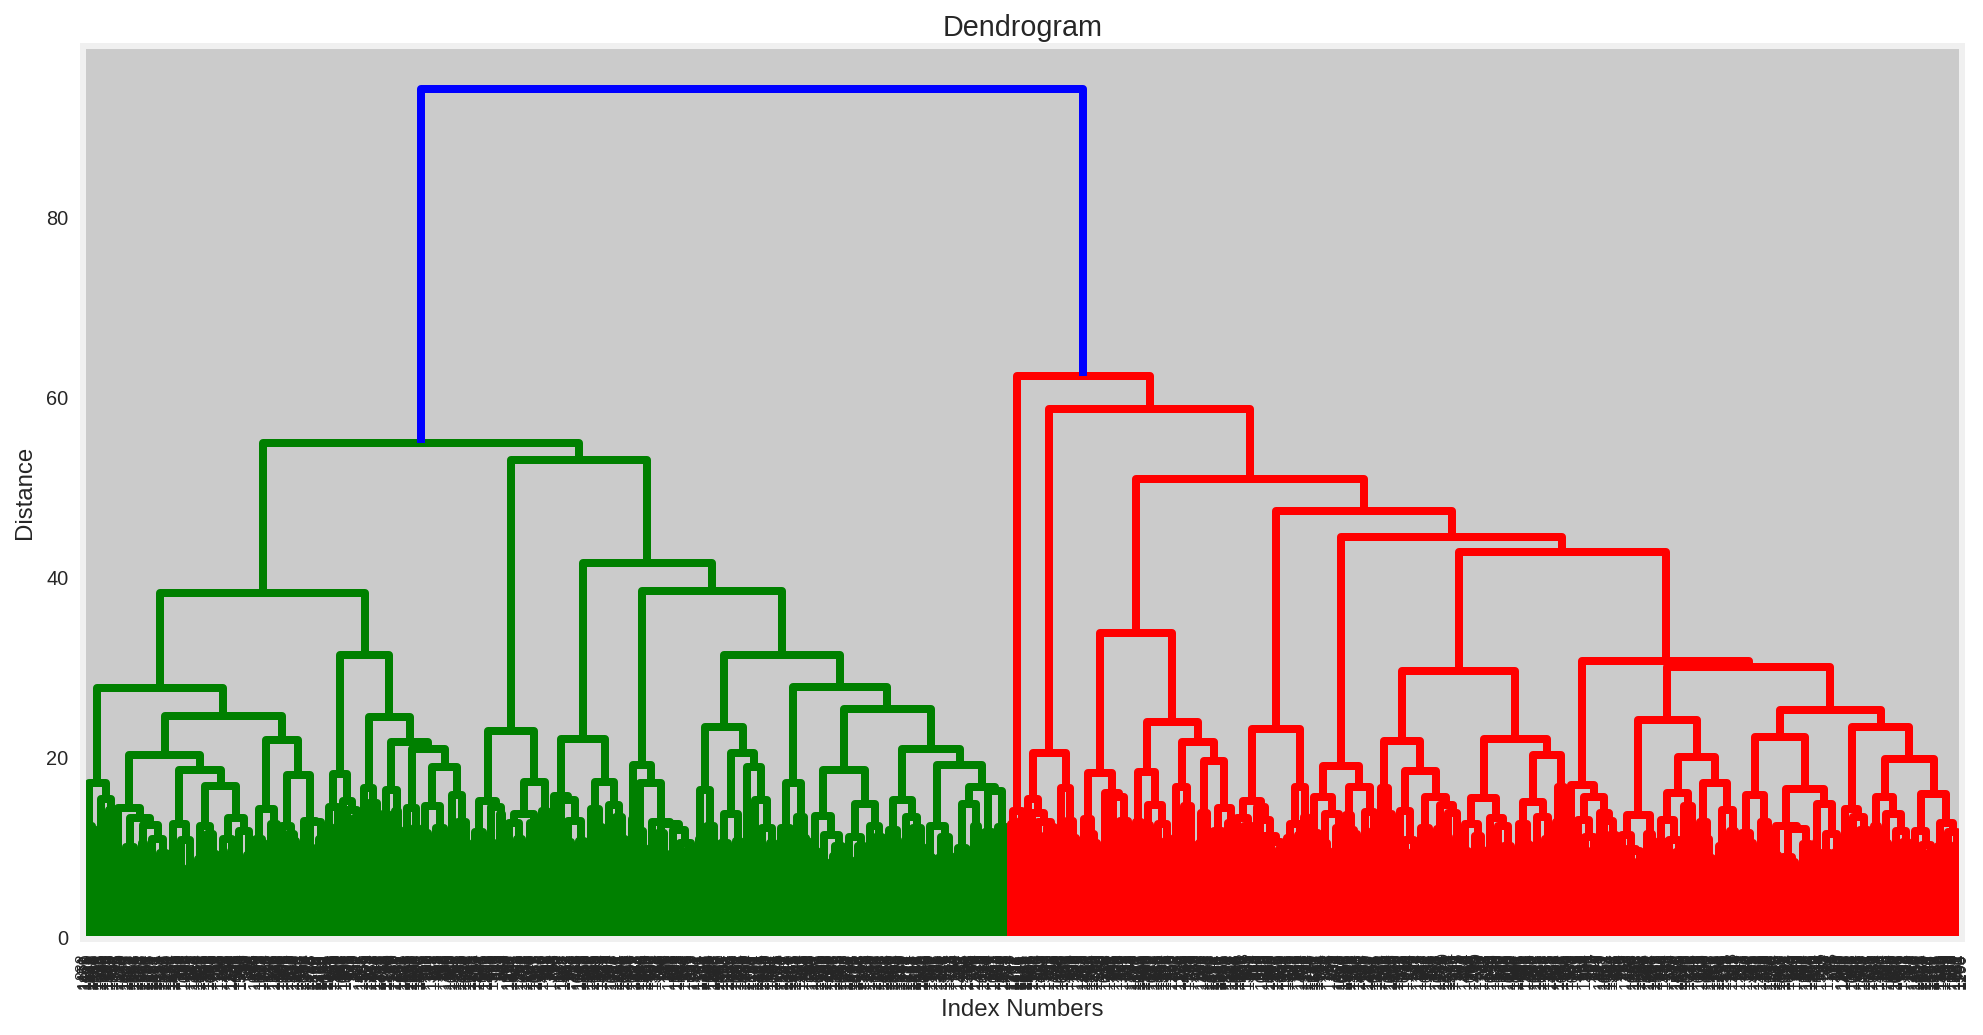

0.216120709368


In [61]:
# this creates a dendrogram with agglomerative hierarchical clustering and shows the
# cophenetic coefficiant
def plot_dendrogram(df):
    
    # Data prep
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward') # the linkage function which creates the clustering similar to KNN mentioned previously
    c, coph_dists = cophenet(Z, pdist(X)) #creates the cophenetic coefficiant, which is a metric for how well clusters form together
    
    # plotting
    plt.figure(figsize=(15,8))
    plt.title('Dendrogram')
    plt.xlabel('Index Numbers')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=8.,
    )
    plt.show()
    
    print c
    
scale = StandardScaler()
X = input_data[euc_cols]
X_n = pd.DataFrame(scale.fit_transform(X))
plot_dendogram(X_n)

While this does show some better clustering in terms of data between clusters, we can see only a few games are part of clusters near the top.

So while these are clusters, they are clustered only on the smallest differences between different groups of data. I would argue these aren't intuitive clusters at all as they are essentially the same cluster with minute differences.

There is one other option which can help with this. The process of Principal Component Analysis (PCA) can help reduce the number of fields clustered on, which can group similar fields without losing the impact of them on the clusters. The below code creates principal components and views the amount of variance with the data each component explains.

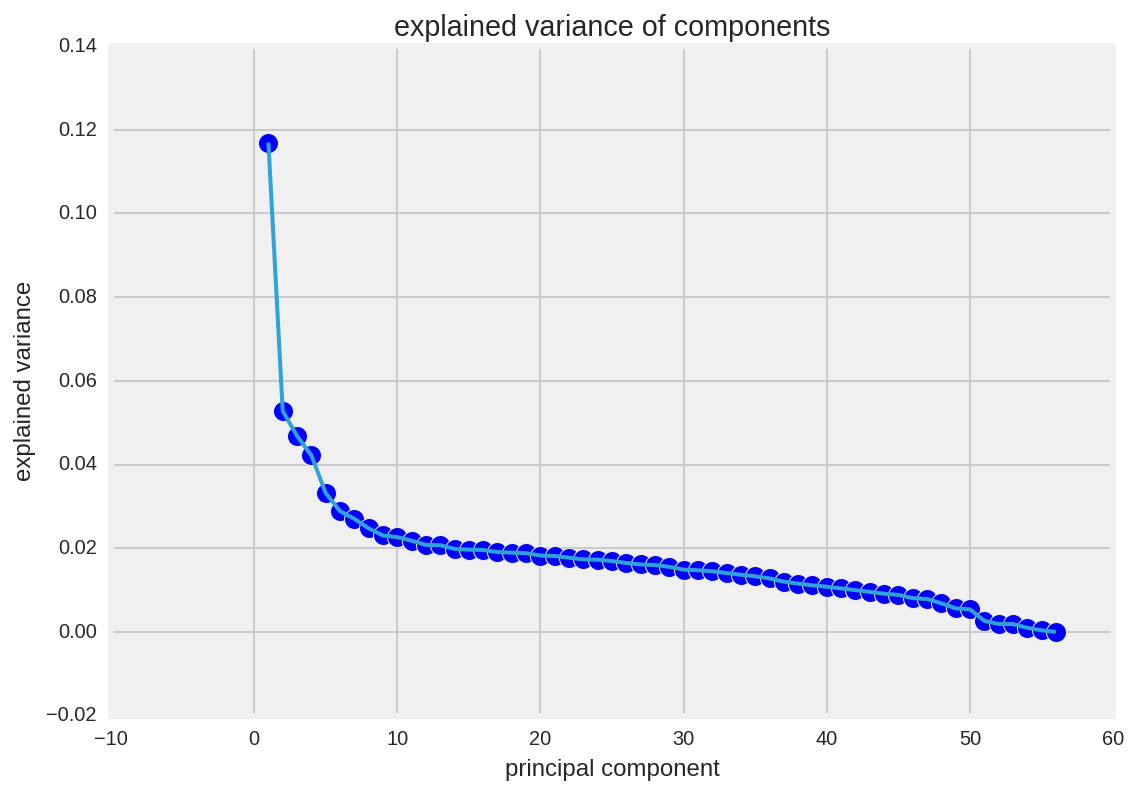

In [37]:
#PCA requires normalization
scale = StandardScaler()
X = input_data[euc_cols]
X_n = scale.fit_transform(X)
#creates PCA dataframe
soccer_pca = PCA()
soccer_pca.fit(X_n)
soccer_pcs = soccer_pca.transform(X_n)
soccer_pcs = pd.DataFrame(soccer_pcs,columns=['PC'+str(i) for i in range(1, soccer_pcs.shape[1]+1)])

#this plots the amount of explained variance for each principal component
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, soccer_pcs.shape[1]+1), soccer_pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, soccer_pcs.shape[1]+1), soccer_pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

Taking a look I decided to take only the first four principal components to reduce confusion for interpreting cluster results. This still explains ~20% of the total variance of the data. I then looked at what fields make up those components. 

In [57]:
#the next blocks are copies which print the positive attributes from highest weight to lowest.
comp_df = pd.DataFrame()
components = []
columns = []
for col, comp in zip(X.columns, soccer_pca.components_[0]):
    if comp>0:
        components.append(comp)
        columns.append(col)
comp_df['Variable'] = columns
comp_df['PCA_Comps'] = components
comp_df.sort_values('PCA_Comps',ascending=False)

,Variable,PCA_Comps
29,home_possession,0.303004
4,home_shots,0.301092
20,home_shoton_other,0.244633
3,home_corners,0.236029
5,home_shots_target,0.234644
25,home_shotoff_other,0.214661
28,home_crosses,0.163374
8,Capacity,0.147546
16,home_goal_other,0.096833
21,home_shoton_bigchance,0.084181


In [51]:
comp_df = pd.DataFrame()
components = []
columns = []
for col, comp in zip(X.columns, soccer_pca.components_[1]):
    if comp>0:
        components.append(comp)
        columns.append(col)
comp_df['Variable'] = columns
comp_df['PCA_Comps'] = components
comp_df.sort_values('PCA_Comps',ascending=False)

,Variable,PCA_Comps
5,half_time_result,0.496070
4,half_time_home_goals,0.400270
16,home_goal_other,0.288602
26,away_crosses,0.155275
7,temp (F),0.135131
22,away_shotoff_headers,0.120706
8,dew (F),0.115882
12,visibility (mi),0.108532
6,Capacity,0.096876
13,home_goal_headers,0.090798


In [53]:
comp_df = pd.DataFrame()
components = []
columns = []
for col, comp in zip(X.columns, soccer_pca.components_[2]):
    if comp>0:
        components.append(comp)
        columns.append(col)
comp_df['Variable'] = columns
comp_df['PCA_Comps'] = components
comp_df.sort_values('PCA_Comps',ascending=False)

,Variable,PCA_Comps
5,home_shots_target,0.247081
2,away_shots_target,0.222053
19,away_shoton_other,0.169649
20,away_shoton_bigchance,0.153284
4,home_shots,0.146530
23,home_shotoff_bigchance,0.140825
1,away_shots,0.133223
16,home_shoton_bigchance,0.130647
10,home_goal_other,0.124447
6,half_time_home_goals,0.120231


In [55]:
comp_df = pd.DataFrame()
components = []
columns = []
for col, comp in zip(X.columns, soccer_pca.components_[3]):
    if comp>0:
        components.append(comp)
        columns.append(col)
comp_df['Variable'] = columns
comp_df['PCA_Comps'] = components
comp_df.sort_values('PCA_Comps',ascending=False)

,Variable,PCA_Comps
0,away_fouls,0.206678
1,away_yellow_cards,0.119777
3,home_fouls,0.085155
7,home_goal_freekicks,0.043987
2,away_red_cards,0.042997
9,home_shotoff_freekicks,0.039557
6,half_time_result,0.034766
5,home_yellow_cards,0.033076
4,home_red_cards,0.031549
11,away_possession,0.030911


I would label these components the following way (purely by looking at the weights and judgement):
    
    PC1 --> Home team offensive statistics (how many shots, crosses, amount of possession)
    PC2 --> Home team performance at half time (half time result in points and goals scored by half time)
    PC3 --> The total amount of shots and chances by both teams (this was the most difficult to interpret)
    PC4 --> The overall physicality of the game (number of fouls and cards for both teams)
    
The next step is to rerun the linkage clustering using only the principal components

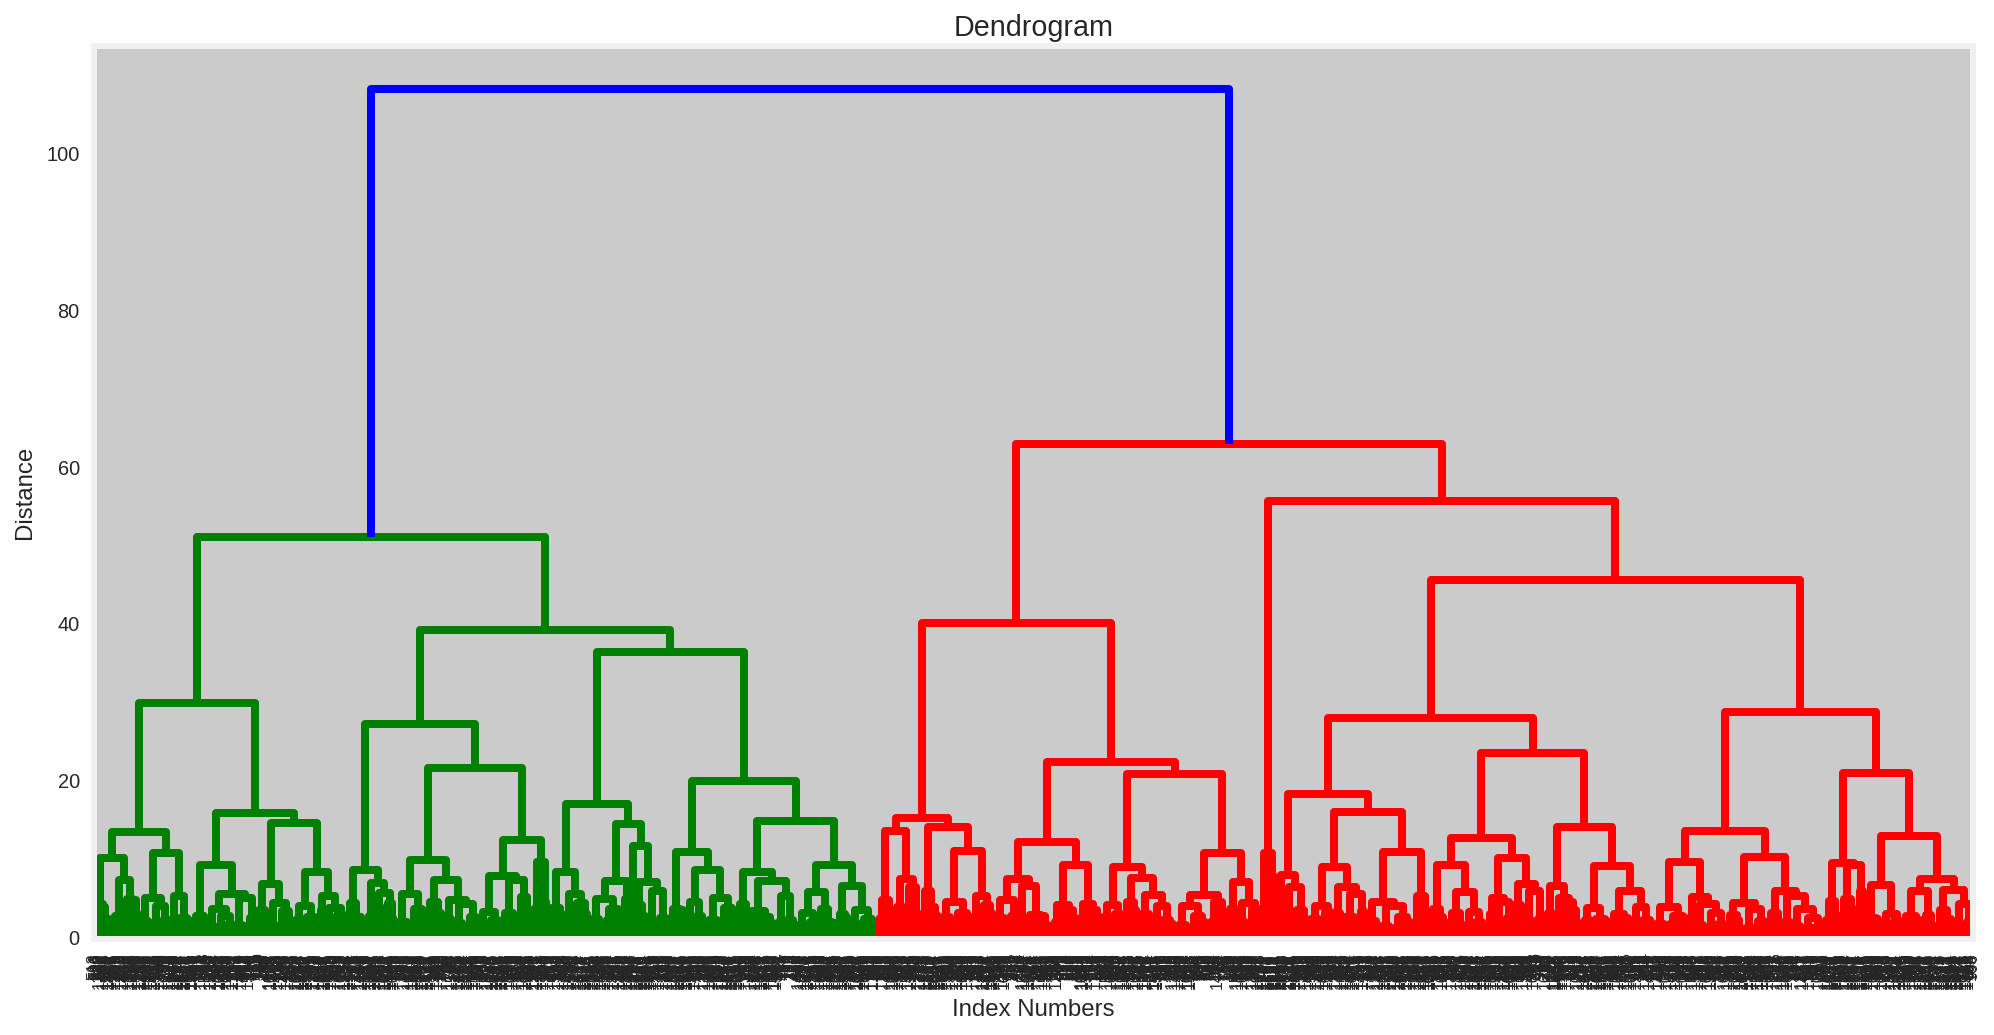

0.38809989759


In [42]:
plot_dendogram(soccer_pcs[['PC1','PC2','PC3','PC4']])

While the cophenetic coefficient is lower, it still performs moderately well, and more importantly, the distance scale is much better. This clustering does not have to grasp at the tiniest differences to split games apart. 

FYI, I also reran the original DBSCAN clustering algorithm on the PCA with unfortunately similar results to previous DBSCAN runs. It seems DBSCAN is not equipped to deal with this data, again for sparsity or similarity between fields.

Now we can check how the clusters look at different distances.

In [44]:
#Creates the clusters at the max distance, taken from the previous dendogram, then prints out the number of data
#points in each cluster and the mean of the four principal components across clusters.
def clusters_array(df,max_dist):
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    clusters = fcluster(Z, max_dist, criterion='distance')
    return clusters

clusters = clusters_array(soccer_pcs[['PC1','PC2','PC3','PC4']],50) #max distance of 50
soccer_pcs['cluster'] = clusters
print soccer_pcs.groupby('cluster').count().reset_index()['PC1']
soccer_output = soccer_pcs[['PC1','PC2','PC3','PC4','cluster']].groupby('cluster').mean().reset_index().T

0    220
1    460
2    331
3     14
4    601
Name: PC1, dtype: int64


This seems to have an even distribution except for the fourth cluster which is an outlier. Let's see if the next split can group those as well.

In [45]:
#Creates the clusters at the max distance, taken from the previous dendogram, then prints out the number of data
#points in each cluster and the mean of the four principal components across clusters.
def clusters_array(df,max_dist):
    X = df.as_matrix(columns=None)
    Z = linkage(X, 'ward')
    clusters = fcluster(Z, max_dist, criterion='distance')
    return clusters

clusters = clusters_array(soccer_pcs[['PC1','PC2','PC3','PC4']],60) #max distance of 60
soccer_pcs['cluster'] = clusters
print soccer_pcs.groupby('cluster').count().reset_index()['PC1']
soccer_output = soccer_pcs[['PC1','PC2','PC3','PC4','cluster']].groupby('cluster').mean().reset_index().T

0    680
1    331
2    615
Name: PC1, dtype: int64


This is the final clustering I settled on. However, as with all unsupervised problems, especially with hierarchical clustering, this end point is a matter of time, effort, and judgement. You could argue the 14 games in the previous clustering should be in their own group. I chose to believe that soccer strategies would be more widespread than for 14 games. 

The final step is seeing how the four principal components differ between the three clusters.

In [47]:
soccer_output

,0,1,2
cluster,1.000000,2.000000,3.000000
PC1,2.189330,-3.045620,-0.781535
PC2,0.341591,1.051297,-0.943514
PC3,0.218251,-0.193462,-0.137195
PC4,-0.290224,-0.050054,0.347838


Using the labels I previously created for each of the four principal components, we can generally group these clusters in the following manner:

    Cluster 1: Strategy where the home team tries to dominate the game but at an even pace. This means keeping possession, not giving away fouls, but also not trying to kill the away team off immediately and potentially leaving room for counters. I would use Barcelona as an example of this strategy: Slow build up, high possession stats, finesse over physicality.
    
    Cluster 2: The home team does not try to keep possession or control the game but attempts to burst the away team down before half time. Still tries not to give away fouls more likely to be physical on defense and tries to reduce the number of chances for both teams. This is a counter-attacking strategy that gives up possession for speed. This is why killing off the game before half-time is important as players will not be able to keep up the defensive responsibilities all game. I would use last year's Leicester City as an example. Extermely quick on the counter, good defensively, usually scoring in the first half.
    
    Cluster 3: This is the one strategy geared toward the away team, who attempts to kill the game by increasing the physicality of the game. This reduces the possession of the home team and their ability to kill the game before half-time. The highest number of fouls and cards (PC4) with limited home attacking stats (PC1) and overall shots (PC3). The away team increases the physicality of the game, limiting home opportunities and tries to take the few opportunities to get ahead and stay ahead. A modern example is Atletico Madrid.

In [59]:
#Looking at the cosine similarity can show how close the clusters are in direction.
cluster_1 = np.array(soccer_output[0],dtype=pd.Series)
cluster_2 = np.array(soccer_output[1],dtype=pd.Series)
cluster_3 = np.array(soccer_output[2],dtype=pd.Series)
print cosine_similarity(cluster_1,cluster_2),cosine_similarity(cluster_2,cluster_3),cosine_similarity(cluster_1,cluster_3)

[[-0.4645764]] [[ 0.5971711]] [[ 0.10423651]]


/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

Surprisingly this shows that the away strategy is similar to the two home strategies. However, it is possible given in many games when the home team tries to counter-attack it will lead the away team to increase the physicality in a bid to stop these fast-paced attacks and not succumb by half-time.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
from sklearn.preprocessing import scale


# Feel free to use my account!
py.sign_in('dyerrington', '62k0c2sses')


import plotly.plotly as py
import plotly.graph_objs as go
import random


trace1 = go.Scatter3d(
    x=soccer_pcs[soccer_pcs['cluster']==1]['PC1'],
    y=soccer_pcs[soccer_pcs['cluster']==1]['PC2'],
    z=soccer_pcs[soccer_pcs['cluster']==1]['PC3'],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x=soccer_pcs[soccer_pcs['cluster']==2]['PC1'],
    y=soccer_pcs[soccer_pcs['cluster']==2]['PC2'],
    z=soccer_pcs[soccer_pcs['cluster']==2]['PC3'],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace3 = go.Scatter3d(
    x=soccer_pcs[soccer_pcs['cluster']==3]['PC1'],
    y=soccer_pcs[soccer_pcs['cluster']==3]['PC2'],
    z=soccer_pcs[soccer_pcs['cluster']==3]['PC3'],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='simple-3d-scatter')

## Conclusion/Issues/Next Steps

The original question I asked was whether unsupervised clustering could create distinct and intuitive groupins from limited soccer stats data, translating them to soccer 'strategies'. 

I believe the final result is inconclusive at best. 

While I did manage to create clusters using hierarchical agglomerative clustering, I had to use PCA, which adds complexity in understanding the differences between clusters in soccer terms. The principal components also only explained a mediocre amount of variance in the original data. Also, the final clusters were still shown to be similar in ways with the cosine similarity. Finally it was still hard to translate the clusters back into the original characteristics (PC3 didn't really distinguish any one team or specific attributes).

It seems an obvious answer now, but sports strategies are extremely complex and specific to teams, players, and situations. Clear strategies should not be able to be gleaned from high level match statistics.

However, I am still pleased that there was some intuition behind both the EDA and final clustering. It makes sense that away teams wouldn't attempt to control games, or that home teams would try to kill games swiftly.

The next steps I would like to switch to supervised learning and see how well these clusters are at predicting outcomes or final goal tallies. Another piece is to continually add games, perhaps expand to other leagues inside or outside of England. 